In [1]:
import pandas as pd

# read data
#reviews_df = pd.read_csv("/Users/liorlavi/Downloads/nyt-comments/CommentsMarch2018.csv")
reviews_df = pd.read_csv("/Users/liorlavi/Downloads/speed-dating-experiment/speed_dating_data.csv", nrows=100000)
# append the positive and negative text reviews
# append the positive and negative text reviews
# reviews_df["message"] = reviews_df["message"]
# create the label
# reviews_df["converted"] = reviews_df["converted"].apply(lambda x: 1 if x > 0 else 0)
# select only relevant columns
#reviews_df = reviews_df[["message", "converted"]]
#reviews_df_head_10000 = reviews_df.head(10000)
reviews_df.head()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x8e in position 17: invalid start byte

In [37]:
# The next step consists in cleaning the text data with various operations:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [38]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
#nltk.download('averaged_perceptron_tagger')
    
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
#reviews_df["commentBody_clean"] = reviews_df["commentBody"].apply(lambda x: clean_text(x))
reviews_df["commentBody_clean"] = reviews_df["commentBody"].apply(lambda x: clean_text(x))


In [39]:
# To clean textual data, we call our custom ‘clean_text’ function that performs several transformations:
#lower the text
#tokenize the text (split the text into words) and remove the punctuation
#remove useless words that contain numbers
#remove useless stop words like ‘the’, ‘a’ ,’this’ etc.
#Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database
#lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)

In [40]:
# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["commentBody"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/liorlavi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [41]:
# We first start by adding sentiment analysis features because we can guess that customers reviews are highly linked to how they felt about their stay at the hotel. 
# We use Vader, which is a part of the NLTK module designed for sentiment analysis. 
# Vader uses a lexicon of words to find which ones are positives or negatives. 
# It also takes into account the context of the sentences to determine the sentiment scores. 
# For each text, Vader returns 4 values:
#a neutrality score
#a positivity score
#a negativity score
#an overall score that summarizes the previous scores
#We will integrate those 4 values as features in our dataset.

In [42]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["commentBody_clean"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["commentBody_clean"].apply(lambda x: len(x.split(" ")))

In [43]:
# Next, we add some simple metrics for every text:
#number of characters in the text
#number of words in the text

In [44]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["commentBody_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["commentBody_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [45]:
# The next step consist in extracting vector representations for every review. 
# The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). This is performed using shallow neural networks. What’s interesting is that similar words will have similar representation vectors.
# Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). 
# Same texts will also have similar representations and that is why we can use those vectors as training features.
# We first have to train a Doc2Vec model by feeding in our text data. By applying this model on our reviews, 
# we can get those representation vectors.

In [46]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["commentBody_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [47]:
# Finally we add the TF-IDF (Term Frequency — Inverse Document Frequency) values for every word and every document.
# But why not simply counting how many times each word appears in every document? 
# The problem with this method is that it doesn’t take into account the relative importance of words in the texts. 
# A word that appears in almost every text would not likely bring useful information for analysis. 
# On the contrary, rare words may have a lot more of meanings.
# The TF-IDF metric solves this problem:
# TF computes the classic number of times the word appears in the text
# IDF computes the relative importance of this word which depends on how many texts the word can be found
# We add TF-IDF columns for every word that appear in at least 10 different texts to filter some of them and reduce the size of the final output.

In [48]:
# show is_bad_review distribution
reviews_df["Label"].value_counts(normalize = True)

KeyError: 'Label'

In [49]:
reviews_df.sample(10)

,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,...,word_zinc,word_zinke,word_zionist,word_zip,word_zombie,word_zone,word_zoo,word_zoom,word_zuckerberg,word_zuma
4727,1519937575,5a982e2a410cf7000162eaf1,1268,Let me get this straight..Democrats have spent...,26171301.0,26171301.0,<br/>,comment,1519937094,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13504,1520092561,5a99783f410cf7000162ee8f,788,Why not 12?,26189207.0,26189207.0,<br/>,comment,1520030760,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82529,1521052744,5aa9578047de81a90120fd22,1255,Ms. Holmes should sere time behind bars. Marth...,26324287.0,26324287.0,<br/>,comment,1521051355,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82950,1521114630,5aa95e8147de81a90120fd6c,1617,Union members who voted for Obama who also vot...,26331950.0,26331950.0,<br/>,comment,1521092364,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11353,1520092400,5a992b58410cf7000162ed8d,1064,I remember peace-treaty-promoting Klingon Chan...,26190794.0,26190794.0,<br/>,comment,1520041626,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50050,1520617231,5aa25b2e47de81a90120c1fc,1755,"Ken Frazier, you are an inspiration for our co...",26263546.0,26263546.0,<br/>,comment,1520617220,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28609,1520347726,5a9dcc0847de81a90120a93d,864,"Heck, I worried when he spent too much time ta...",26221013.0,26221013.0,<br/>,comment,1520346778,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18519,1520175066,5a9af7d247de81a901209ada,1412,The country was polarized starting in 2009 by ...,26198770.0,26198770.0,<br/>,comment,1520143765,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76673,1520998980,5aa86a2547de81a90120ec56,1656,"When you write Pompeo is ""kindred soul"" of Tru...",26314975.0,26314975.0,<br/>,comment,1520997737,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22541,1520272368,5a9ca2df410cf7000162f021,836,It could be something as simple as Trump havin...,26207822.0,26207822.0,<br/>,comment,1520260000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
from functools import reduce
def make_ngram(df, col, N):
    return reduce(
        list.__add__, 
        (list("_".join(j) for j in nltk.ngrams(i.replace('↵', ' ').replace('|','').replace(':', '').split(), N))
        for i in df[col].values), [])

In [ ]:
bigram = pd.Series(make_ngram(reviews_df, "commentBody_clean", 2))
trigram = pd.Series(make_ngram(reviews_df, "commentBody_clean", 3))

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

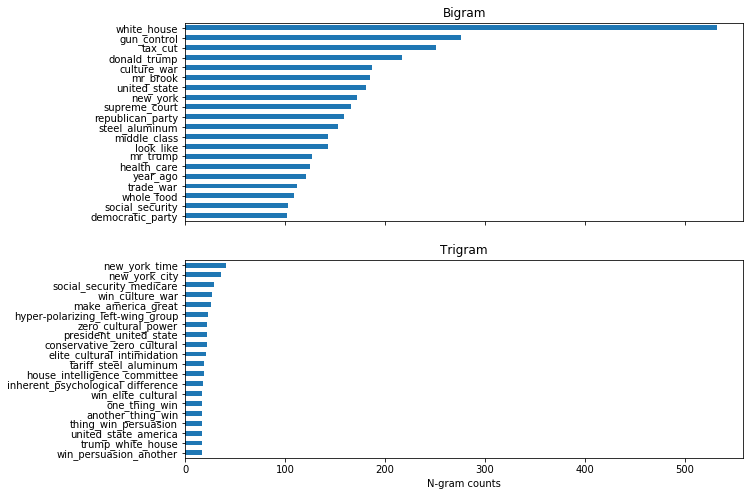

In [27]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8), sharex=True)
pd.value_counts(bigram).head(20)[::-1].plot.barh(ax=ax1, rot=0)
pd.value_counts(trigram).head(20)[::-1].plot.barh(ax=ax2, rot=0)
ax1.set_title('Bigram')
ax2.set_title('Trigram')
ax2.set_xlabel("N-gram counts");

In [28]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [29]:
def show_wordcloud(data, title = 'Post-booking messages Word Cloud'):
    wordcloud = WordCloud(
        background_color = 'white',
        
        max_words = 100,
        max_font_size = 45, 
        scale = 25,
        random_state = 1
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 0.9)

    plt.imshow(wordcloud)
    plt.show()
    
    # print wordcloud

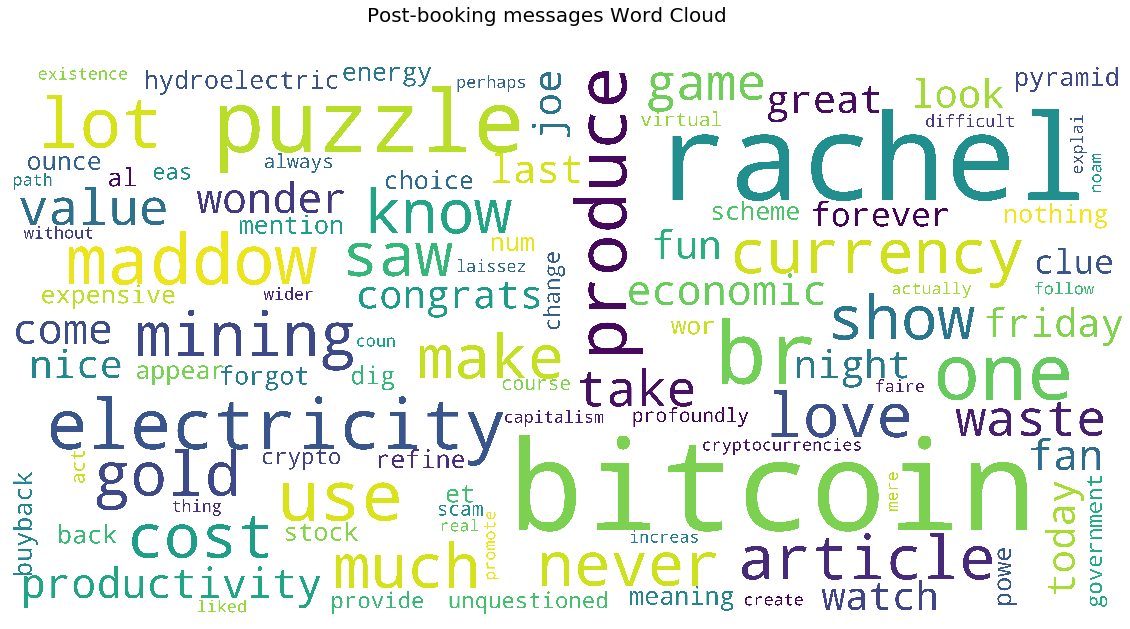

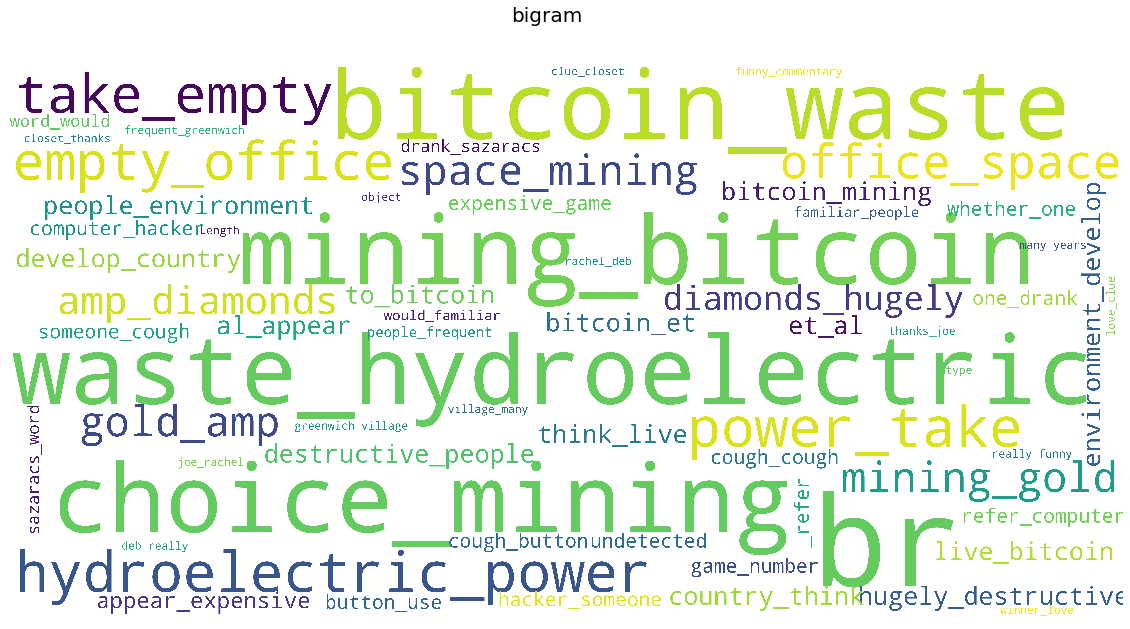

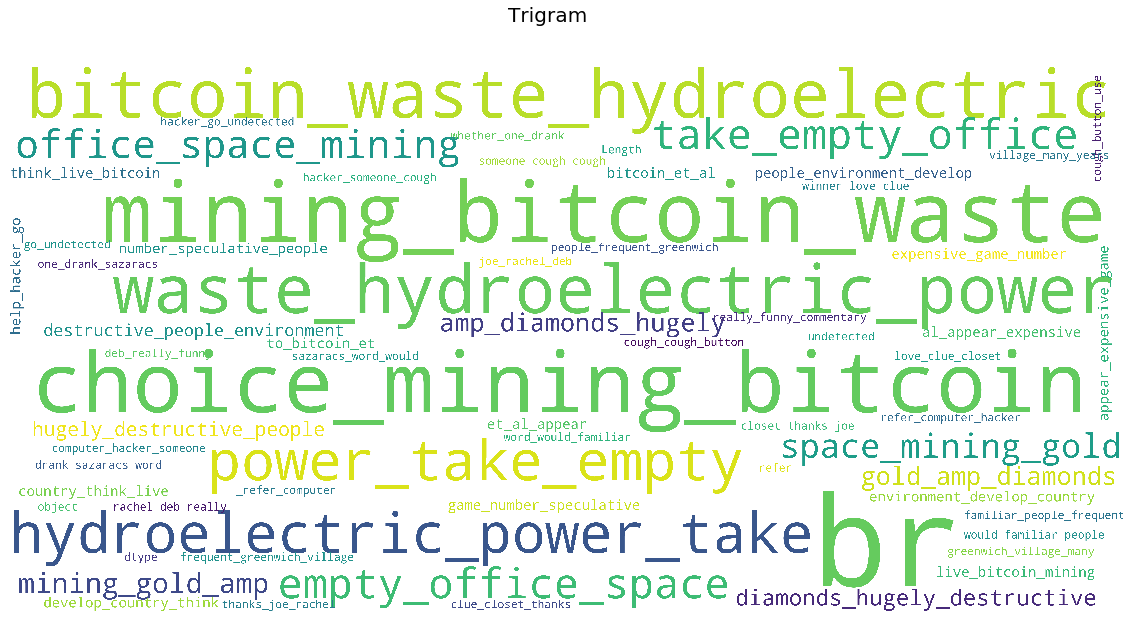

In [30]:
show_wordcloud(reviews_df["commentBody_clean"])
show_wordcloud(bigram, title="bigram")
show_wordcloud(trigram, title="Trigram")

In [33]:
# Most of the words are indeed related to the hotels: room, staff, breakfast, etc. 
# Some words are more related to the customer experience with the hotel stay: perfect, loved, expensive, dislike, etc.


In [34]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["commentBody_clean", "pos"]].head(10)


,commentBody_clean,pos
9563,like father like daughter,0.714
8930,way confidence ability smart,0.686
1786,beautiful thank,0.681
4863,place absolutely delicious great choice ultra ...,0.665
3686,much winning,0.665
3960,thanks trump retirement account love win,0.638
4306,"tweet want free fair smart trade!"".<br/><br/>i...",0.635
8726,write sunshine best disinfectant free press hope,0.635
637,love see diane feinstein play trump like fiddle,0.629
3274,“i great amp magnificent oz!”,0.624


In [35]:
# lowest negative sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["commentBody", "neg"]].head(20)


,commentBody,neg
8402,No similar audience with gun violence victims?,0.786
7839,once a coward always a coward.,0.750
9180,All chaos. No theory.,0.747
3571,"What, no parade? Sad.",0.726
3821,"Stupid human tricks, ... again.",0.620
3820,"I'm no economist, but I know this is yet anoth...",0.618
8036,"Stupid, selfish, and unprincipled people make ...",0.596
6311,Too bad you didn't support Bernie.,0.590
9324,Chaos: fancy term for total incompetence and ...,0.570
8099,Trump and poor attention span is killing us!,0.565


In [ ]:
# Some errors can be found among the most negative reviews: 
# Vader sometimes interpret ‘no’ or ‘nothing’ as negative words whereas they are sometimes used to say that there were no problems with the hotel. 
# Fortunately, most of the reviews are indeed bad ones.